## recommendation
Multi-armed-bandit(MAB)는 단순히 AB 테스트의 확장을 넘어서 추천알고리즘으로도 많이 사용되고 있다. 특히 넷플릭스는 MAB를 적극활용한 추천시스템을 제공하고 있다. 사실 기본적인 원리와 바탕은 일반적인 MAB와 동일하다. 다만 목적에 따라 달리 사용되는 그 '아이디어'와 사고의 흐름은 알아야 할 것 같다.  
AB테스트는 서로다른 대안에 대해서 더 나은 안, 더 전환율이 높은 안을 선택하는 가장 직관적이고 효과적인 방법이다. MAB는 AB테스트와 달리 매 시기마다 유저정보를 통해 학습하고 업데이트되며, 이러한 내용은 실시간으로 유저들에게 제공된다. **추천**도 마찬가지이다. 전환율의 개념을 동일하게 추천에 적용할 수 있다. 유저들이 좋아할만한 내용, 더많이 클릭할 만한 내용들을 추천하여 결과적으로 전환율을 높이는 것이고 이는 기존의 AB테스트나 MAB의 원리와 동일하다.

## 1. basic approach

기본적으로 유저들의 클러스터를 미리 나누어 분석하려고 한다.

### setting 
* bandit은 추천하는 서비스의 종류. 예를들면 영화의 장르
* 유저마다 클러스터가 구분되어있음. 영화 선호별 구분이 이미 되어있음.
* 구분된 클러스터별 binary bandit의 확률이 다름. -> 영화에 대한 선호가 다름.
* 목적은 클러스터별 전환율이 높은 서비스를 제공하는것. 선호하는 영화를 추천해주는것

In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
def draw(param_prob, k):
    """
    ex) bandit_list = ['cont1','cont2',...,'contN']
        k = 0 -> 'cont1'
        param_prob : 해당 bandit의 전환율 , unknown
    """
    
    reward = np.random.binomial(1, param_prob[k])
    regret = np.max(param_prob) - param_prob[k]
    return reward, regret
        

    
class policy:    
    
        
    def epsilon(self, success, fail, epsilon):
        
        if np.random.rand() < epsilon or success.sum()==0:
            k = np.random.randint(0,len(success),1)[0]
    
        else :
#           mean, var = calculator(1+success, 1+fail) 베타분포를 이용하는경우
            mean = success/(success+fail)
            k = np.argmax(mean)
        return k    
    
    
    
    def thompson(self, success, fail, epsilon):
        """
        output: 선택된 bandit 번호
        """
       # exploration : 랜덤선택
        if np.random.rand() < epsilon:
            k = np.random.randint(0,len(success),1)[0]

        # exploitation : 샘플링
        else :
            rvs = np.random.beta(1+success, 1+fail)
            k = np.argmax(rvs)
        return k    
    
    def UCB(self, success, fail, epsilon):
        # exploration : 랜덤선택
        if np.random.rand() < epsilon or success.sum()==0:
            k = np.random.randint(0,len(success),1)[0]

        # exploitation : upper confidence bound
        else :
            Q = (success/(success+fail)) # 각 bandit의 평균 성공확률
            c = 2
            N = success+fail # 각 bandit의 총 선택된 횟수.
            k = np.argmax(Q + c*np.sqrt(np.log(N.sum())/N))
        return k    
    

In [8]:
n_cluster=8
n_bandit = 10
n_draws = 500

reward_array = {}
count_array = {}
regret_array = {}

for i in range(n_cluster):
    reward_array[i] = np.zeros((n_bandit, n_draws))
    count_array[i] = np.zeros((n_bandit, n_draws))
    regret_array[i] = np.zeros((n_bandit, n_draws))


In [10]:
param_prob = [np.random.random(n_bandit)*0.5 for i in range(n_cluster)] # 클러스터별 bandit의 모수 set
cl_info = np.random.randint(0,n_cluster,1)[0] # 추후 클러스트 분류도 다시 생각해야할듯.

success = reward_array[cl_info].sum(axis=1)
fail = count_array[cl_info].sum(axis=1) - success


In [11]:
pc = policy()
k = pc.thompson(success, fail, 0.1)
reward, regret = draw(param_prob[cl_info], k)

In [12]:
reward_array[cl_info][0, k] = reward
count_array[cl_info][0, k] = 1

In [161]:
def simulator(n_cl, n_band, n_draw):
    n_cluster = n_cl
    n_bandit = n_band
    n_draws = n_draw

    reward_array = {}
    count_array = {}
    regret_array = {}

    for i in range(n_cluster):
        reward_array[i] = np.zeros((n_bandit, n_draws))
        count_array[i] = np.zeros((n_bandit, n_draws))
        regret_array[i] = np.zeros((n_bandit, n_draws))

        
    param_prob = [np.random.random(n_bandit)*0.5 for i in range(n_cluster)] # 클러스터별 bandit의 모수 set
   
    
    for i in range(n_draws):
        
        for j in range(n_cluster):
        
        # 해당클러스터 계산
            success = reward_array[j].sum(axis=1)
            fail = count_array[j].sum(axis=1) - success

            pc = policy()
            k = pc.thompson(success, fail, 0.1) # 
            reward, regret = draw(param_prob[j], k)

            reward_array[j][k, i] = reward
            count_array[j][k, i] = 1
            regret_array[j][k, i] = regret
    
    return reward_array, count_array, regret_array, param_prob

In [162]:
reward,count,regret,param = simulator(5,5,1000)

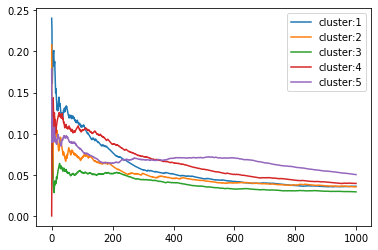

In [185]:
for i in range(5):
    plt.plot(regret[i].sum(axis=0).cumsum()/(np.arange(1000)+1), label=f'cluster:{i+1}')
plt.legend()
plt.title('Expected regret')

## 2.logistic bandit

* 각 feature의 linear combination을 통해 가장 높은 값을 가지는 option이 선택됨
* policy 선택과정이 필요 없는걸까


In [384]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# 기본 세팅
n_user = 1000 # 1000명의 유저
n_feature = 2 # 고객정보 수
n_movies = 4 # 제공 option 수

sex = np.random.binomial(1, 0.5, n_user) # 성별
data = stats.gamma(10, scale = 3).rvs(n_user)
age= list(map(int, data)) # 나이
const = np.ones(n_user) # 상수항

D = np.array([sex,age,const]).T # feature 데이터 셋
reward = np.random.randint(0,2,1000) # 랜덤 reward

# 1000명의 데이터로 추론한 모수값(feature beta)
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(D, reward)

# option별 차이 및 노이즈
n1 = [logreg.coef_[0][0]*0.1 * np.random.random(1)[0] for i in range(4)]
n2 = [logreg.coef_[0][1]*0.1 * np.random.random(1)[0] for i in range(4)]
n3 = [logreg.coef_[0][2]*0.1 * np.random.random(1)[0] for i in range(4)]

In [385]:
# 실제로 우리가 모르는 모수가 존재함.
# 실제 모수에 의해서 값이결정되는 과정.
# bandit k 마다 모수가 다름.
class MAB:
    
    def __init__(self):
        self.weights = {}
        self.weights[0] = [logreg.coef_[0][0]+n1[0], logreg.coef_[0][1]+n2[0], logreg.coef_[0][2]+n3[0]]
        self.weights[1] = [logreg.coef_[0][0]+n1[1], logreg.coef_[0][1]+n2[1], logreg.coef_[0][2]+n3[0]]
        self.weights[2] = [logreg.coef_[0][0]+n1[2], logreg.coef_[0][1]+n2[2], logreg.coef_[0][2]+n3[0]]
        self.weights[3] = [logreg.coef_[0][0]+n1[3], logreg.coef_[0][1]+n2[3], logreg.coef_[0][2]+n3[0]]

    def draw(self, k, x):
        """
        k: 선택된 bandit(option) number
        x: context.
        """
        
        prob_dict = {}
        for bandit in self.weights.keys():
            f_x = self.weights[bandit][0]*x[0] + self.weights[bandit][1]*x[1] + self.weights[bandit][2]*x[2]
            prob = 1/(1+np.exp(-f_x))
            prob_dict[bandit] = prob
            
        reward = np.random.binomial(1,p=prob_dict[k])
        regret = max(prob_dict.values()) - prob_dict[k]
        prob = prob_dict[k]
        return reward,regret, prob
    

# 과거 데이터 / 선택된 bandit(option), x는 linear combination, 결과feedback.
class linear_bandit:
    
    def __init__(self, n_bandits):
        # 실제 정보 
        self.n_bandits = n_bandits
        self.epsilon = 0.1
        self.coef = []
            
    def fit(self, data, actual_x):
        
        # sgd object
        logreg = LogisticRegression(fit_intercept=False)
        
        # fitting to data
        logreg.fit(data.iloc[:,1:-1].values, data['reward'])
        
        self.coef.append(logreg.coef_[0])
        
        # returning probabilities
        return logreg.predict_proba(actual_x)[0][1]
    
    def choose_bandit(self, round_df, actual_x):
        
        # 초기 데이터가 많이 없는 경우는 random하게 선택해버림
        if round_df.groupby(['k','reward']).size().shape[0] != 8: # 각 bandit별 reward(0,1) 데이터가 모두  나옴
            best_bandit = np.random.randint(0,self.n_bandits,1)[0]
            
            return best_bandit
        
        # 데이터가 충분한 경우 과거데이터 + feature 종합. theta 계산 가능
        else :
            # predictinng for two of our datasets
            bandit_scores = round_df.groupby('k').apply(self.fit, actual_x=actual_x)

            # get best bandit
            best_bandit = int(bandit_scores.idxmax())    
        
        
        # epsilon 만큼의 탐색. 이건 조건적으로 넣고 뺴도됨.
        if np.random.random(1) < self.epsilon:
            best_bandit = np.random.randint(0,self.n_bandits,1)[0]
        else :
            pass    
        
        return best_bandit
        

In [394]:
lb = linear_bandit(4)
mab = MAB()

k_list = []
reward_list = []
regret_list= []
round_df=pd.DataFrame({'k':[],'x1':[],'x2':[],'x3':[] ,'reward':[]})

user = D
k = lb.choose_bandit(round_df, user)
x = user[0]
reward,regret, prob = mab.draw(k, x)

In [395]:
N_DRAW = 1000
for i in range(N_DRAW):
    k = lb.choose_bandit(round_df, user)
    x = user[i]
    reward,regret, prob = mab.draw(k, x)
    temp_df = pd.DataFrame({'k': k, 'x1': x[0], 'x2':x[1],'x3':x[2],'reward': reward}, index=[i])
    round_df = pd.concat([round_df, temp_df])
    
    k_list.append(k)
    reward_list.append(reward)
    regret_list.append(regret)

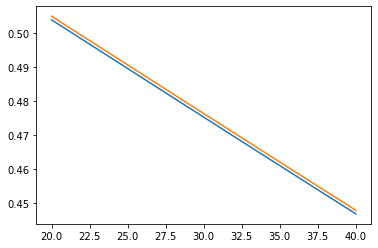

In [431]:
# 나이 변수에 따른 확률값 p 차이
x = np.linspace(20,40,100)
f_x1 = mab.weights[0][1]*x + mab.weights[0][2]
f_x2 = mab.weights[0][0] + mab.weights[0][1]*x + mab.weights[0][2]
p1 = 1/(1+ np.exp(f_x1))
p2 = 1/(1+ np.exp(f_x2))
plt.plot(x,p1)
plt.plot(x,p2)

(array([254.,   0.,   0., 252.,   0.,   0.,   2.,   0.,   0., 492.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

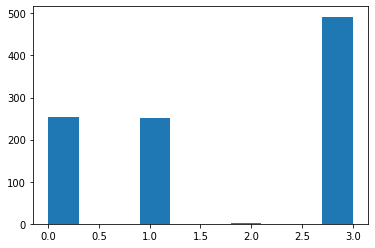

In [437]:
# 가장 확률값이 높은 경우
plt.hist(np.matmul(D,th.T).argmax(axis=1))

## 3.Multivariate
* 제공하는 옵션이 multiple인 경우는 ..?
* 무엇에 따른 전환유무 차이인지 알 수 있을까?

## 4.Mini-batch

## 5.Dirichlet Process

1000

In [439]:
class OnlineLogisticRegression:
    
    # initializing
    def __init__(self, lambda_, alpha, n_dim):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_
        self.alpha = alpha # exploitation/exploration 가중.
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights / 평균이 0이고 
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
        return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
        
        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [441]:
class ContextualMAB:
    
    # initialization
    def __init__(self):
        
        # we build two bandits
        self.weights = {}
        self.weights[0] = [0.0, 1.6]
        self.weights[1] = [0.0, 0.4]
    
    # method for acting on the bandits
    def draw(self, k, x):
        
        # probability dict
        prob_dict = {}
        
        # loop for each bandit
        for bandit in self.weights.keys():
        
            # linear function of external variable
            f_x = self.weights[bandit][0] + self.weights[bandit][1]*x

            # generate reward with probability given by the logistic
            probability = 1/(1 + np.exp(-f_x))
            
            # appending to dict
            prob_dict[bandit] = probability
        
        # give reward according to probability
        return np.random.choice([0,1], p=[1 - prob_dict[k], prob_dict[k]]), max(prob_dict.values()) - prob_dict[k], prob_dict[k]

In [444]:
cmab = ContextualMAB()
X = np.random.uniform(-6, 6, 10)
y = np.array([cmab.draw(0, x)[0] for x in X])

# OLR object
online_lr = OnlineLogisticRegression(0.5, 1, 1)
online_lr.fit(X.reshape(-1,1), y)

In [451]:
online_lr.q

array([4.44644029])

In [ ]:
# closing other figures
plt.close('all')

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = norm_dist(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(X, y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()